# Neuhaus et al 2021 Ice Temperature and Porewater Solute Models

In [Neuhaus et al., 2021](https://tc.copernicus.org/articles/15/4655/2021/tc-15-4655-2021-supplement.pdf), the authors use molecular diffisuvity models, borehole temperature, and some measurements of borehole salt content to model the timing of retreat and readvance of the West Antarctic Ice Sheet during the early Holocene. Then, they use the windows of time that the borehole sites were open to model the radiocarbon age of the sediment using a peculiar method of constant supply of $^{12}C$ and varying supply of $^{14}C$ (only when the area was connected to the ocean, i.e. seaward of the grounding line) to constrain the solute transport and borehole temperature models. 

Here we emulate their borehole temperature model and adjust for SLM variables and measurements. 

In the cells below, we import packages and initialize the model as they derived it in order to perform sensitivity tests of the radiocarbon age. The goal is to assess radiocarbon age based on their model in comparison with measured radiocarbon ages and derived maximum age of readvance of the WAIS from [Venturelli et al., 2023](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2022AV000846). The measured age constraint was measured after this model was published, therefore it could not be used as an additional constraint. 

In [1]:
#Load packages
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import math
import neuhaus_fcns as nf       #Functions to generate original plots easily. 

#Set up initial radiocarbon conditions
t_earliest = 8000       #earliest possible time the grounding line could have retreated behind field sites (same for SLM?)
n_0 = 0                 #Initial amount of 14C in the sediment, prior to Holocene retreat.
Fm_max = math.exp(-1000/8033)
                        #Fraction modern of the "modern" isopod carbon measured at the Whillans Grounding Zone
t_readvance = 4000      #Calendar years before present of ice sheet retreat poleward of SLM
ti = 4000               #Calendar years before present of ice sheet readvance seaward of SLM
a = 9.23*10**(-18)      #Accumulation rate of 14C, g/yr/100g sediment
A = 9*10**(-6)          #Accumulation rate of 12C, g/yr/100g sediment
N_0 = 0.28              #Non-zero initial condition of %TOC (g/100g sediment)
tau = 8033              #mean lifetime of 14C based off of the Libby half life.
modern_ratio = 1.176810*10**(-12)
                        #Modern ratio of 14C/12C to transform to fraction modern - from the Neuhaus et al. text. 

#Set up initial temperature model conditions
S = 34                  #PSU
ice_acc_rate = 0.15     #m/yr, Waddington et al, 2005
surf_T = -25            #temperature at the surface of the ice (Engelhardt, 2004)

#Destination directory for figures and data:
dest_dir = 'C:/Users/beros/Box/UDrive_brosenheim/My_Documents/Service/Conferences and Presentations/WAIS/WAIS 2025 - Whidby'






## Conductivity Model
Ultimately, we are not concerned with the temperature profile of the ice because the temperature profile at Mercer Subglacial Lake (SLM) was not steep. In cases where basal temperature gradients were not anomolously steep, Neuhaus et al., 2020 employed a diffusion model, ignoring vertical advection, of the porewater ion concentrations. At SLM, we have considerably deeper ion concentrations than at Whillans Subglacial Lake (SLW). There were two phases to this model: 

### Phase 1: Seawater exposure
For some length of time, the sediments under SLM were exposed to seawater. **This is the time range that we are interested in because a time range is more interesting to modelers than just a date of seaward grounding line advance.** That length of time was denoted as $T_0$ in Neuhaus et al., 2020. 

### Phase 2: Re-grounding, basal meltwater exposure
The length of time, $T_i$ after regrounding that the sediments were exposed to basal meltwater is modeled in Phase 2. 

We use sediment porewater measurements from multicores as well as two points from porewater squeezed from a large gravity core. The diffusion coefficient was calculated using the equation from Li and Gregory (1974):
$$
D_{sed} = D \frac{\alpha}{\theta^2}
$$

We assume that $\alpha$ , a fraction close to 1, is equal to 1. We also assume that $\theta$ , toruosity, is related to the porosity by:
$$
\theta^2 = 1 - ln(\phi^2)
$$

In Neuhaus, $ \phi $ is considered to 0.4. 

The diffusion model was instantaneously switched between marine and subglacial conditions. Assuming the area was under subglacial conditions for initially 10's of thousands of years, Neuhaus et al., 2020 used an analytical solution of the following equation for each solute for which they had data: 
$$
\frac{C-C_0}{C_s-C_0} = erfc\left(\frac{y}{2\sqrt{D_{sed}t}}\right)

('Composite Depth (median)', 'cm')


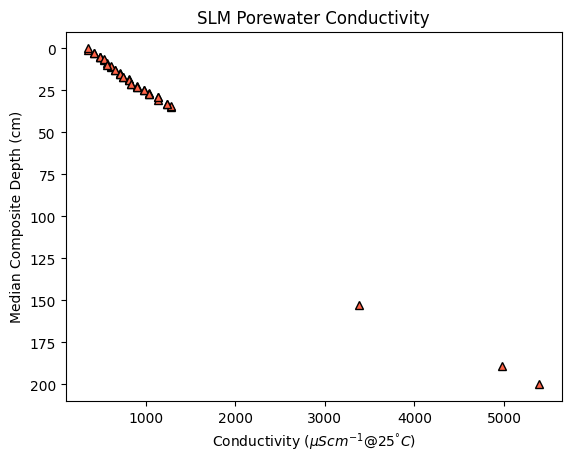

In [2]:
#Plot SLM Porewater salinity

pw_df = pd.read_excel('Davis_Supplemental_File_1.xlsx', sheet_name='Sheet1', skipfooter=3, header=[0,1])

#make plottable listes from annoying multi-index dataframe
print(pw_df.columns[3])
cond = [c for c in pw_df.loc[:, ('Conductivity', '(µS cm-1 @ 25°C)')]]
depth = [d for d in pw_df.loc[:, ('Composite Depth (median)', 'cm')]]

fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(cond, depth, linestyle='', marker='^', mec='k', color='tomato')
ax.yaxis.set_inverted(True)
ax.set(ylabel='Median Composite Depth (cm)', xlabel='Conductivity ($\mu S cm^{-1} @ 25^°C$)', title='SLM Porewater Conductivity')
#Construct a list of unique depths for which we have data to later calculate residuals of the A-D model:
depths_set = sorted(list(set(depth)))

plt.savefig(dest_dir+'/Porewater_Conductivity_SLM.png', dpi=600)


Number of time steps in Phase 2:  1500
Shape of c_profiles_p1 should be  4700 - 1500  divided by the time step:  (3200, 200)
Diffusion and advection being employed.
Shape of phase_2_profiles =  (1500, 200)


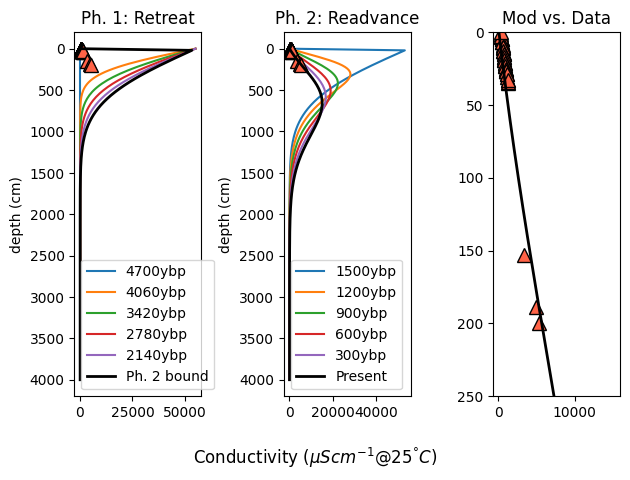

In [20]:
#Top level variables
phi = 0.4                               #Neuhaus et al. approximation, constant in their work
D_Cl = 0.0113*100*100                   #cm^2/y, Diffusivity of chloride ion, Table 2 of Neuhaus et al., 2020
D_Ca = 0.00416*100*100                  #Cm^2/y, Diffusivity of calcium ion, Table 2 of Neuhaus et al., 2020

u = 0.0001                              #Advection velocity if decide to incorporate advection
L = 4000                                #cm, max depth in centimeters, in Neuhaus et al., 2020 it was 10000 cm
depth_step = 20                         #cm, depth step is the vertical resolution which was 50 cm in Neuhaus et al., 2020
time_step = 1                           #year, time resolution to run the analytical model
C_0 = 100                               #microseimens per centimeter @25 degrees C. 
C_i = 55000                             #microseimens per centimeter for seawater
Nx = L//depth_step                      # number of spatial points

#Phase-level variables
#Phase 1: Analytical solution - solute diffusion:
T_0 = 4700                              #number of years phase 1 - How many years is the site open to seawater
Nt_T0 = T_0//time_step                  # number of time steps, phase 1

#Phase 2 - Finite difference diffusion model
T_1 = 1500                        #Number of years after readvance, and to present. How long ago did grounding line advace past SLM?
Nt_T1 = T_1//time_step                  # number of time steps, phase 2
print('Number of time steps in Phase 2: ', Nt_T1)

#derived values
dx = L/Nx
dt_0 = T_0/Nt_T0
dt_1 = T_1/Nt_T1

#Run Phase 1 Model:
#Set diffusion coefficient:
D = (1/(1-math.log(phi**2)))*D_Cl
#D = D_Cl
xes, c_profiles_p1 = nf.Neuhaus_analytical_solution(T_0, T_1, time_step, L, depth_step, D, C_i, C_0)

#Run Phase 2 Model:
z, phase_2_profiles, tag = nf.Neuhaus_PW_solute_model(c_profiles_p1, D, T_1, C_0, L, depth_step, time_step, u=0.15, check_handoff=False)
print('Shape of phase_2_profiles = ', phase_2_profiles.shape)

#Plot both phases:
#fig, ax = visualize_allphases(c_profiles_p1, phase_2_profiles, pw_df, T_0, T_1, Nt_T0, Nt_T1, z, slice=5)


#Plot Phase 2 Model:
fig, ax = nf.visualize_allphases(c_profiles_p1, phase_2_profiles, pw_df, T_0, T_1, z, slice=5)
plt.tight_layout()
plt.savefig(dest_dir+'/All_phase_diagram_with_data_T0_'+str(T_0)+'_T1_'+str(T_1)+tag+'.png', dpi=600)


In [4]:
def modify_array(arr):
    arr[0] = 99  # This modification will only affect the copy

original_array = np.array([1, 2, 3])
copied_array = original_array.copy()  # Create a copy
bad_coppied_array = original_array
modify_array(copied_array)
bad_coppied_array[0] = -99

print(f"Original array: {original_array}")
print(f"Modified copy: {copied_array}")
print(f"Viewed copy: {bad_coppied_array}")


Original array: [-99   2   3]
Modified copy: [99  2  3]
Viewed copy: [-99   2   3]


Shape of c_profiles_p1 should be  6300 - 1700  divided by the time step:  (4600, 100)
<class 'numpy.ndarray'>
Diffusion only model will be used. Specify kwarg u to add advection.
Nt =  1700
Time step:  1700
Time step:  1360
Time step:  1020
Time step:  680
Time step:  340


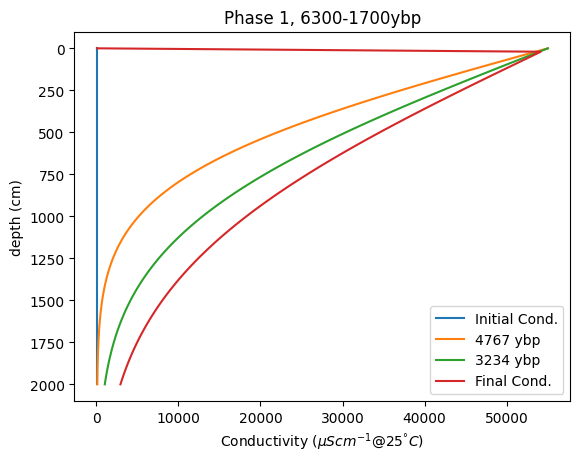

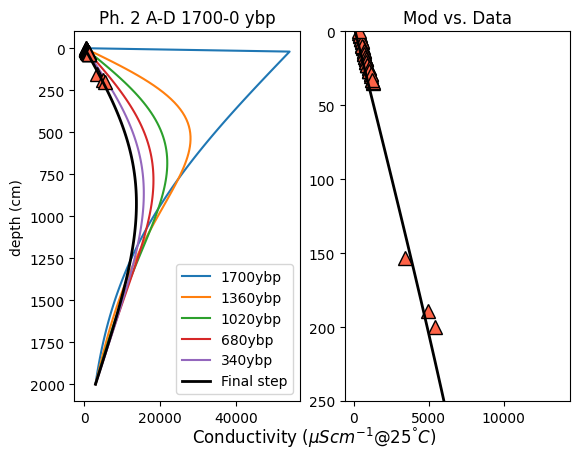

In [15]:
#Phase 1 Practice:

L = 2000                                #cm depth scale, sediment
depth_step = 20                         #cm, depth resolution of calculations
T = 1700                                #years, amount of time that the system is open to the ocean
D = 0.0113*100*100                      #cm^2/y, Diffusivity of chloride ion, Table 2 of Neuhaus et al., 2020



Nx = L//depth_step                      # number of spatial points
z = np.linspace(0, L, Nx)

xes, phase1_arr = nf.Neuhaus_analytical_solution(T_0, T_1, time_step, L, depth_step, D, C_i, C_0)
print(type(phase1_arr))
z, phase_2_profiles, _ = nf.Neuhaus_PW_solute_model(phase1_arr, D, T_1, C_0, L, depth_step, time_step, u=None, check_handoff=False)


#Plot initial profile and some other time slices from Phase 1:
fig, ax = nf.visualize_phase1(phase1_arr, z, T_0, time_step)
plt.savefig(dest_dir+'/Phase1_profiles_example.png', dpi=600)
fig_diff, ax_diff = nf.visualize_phase2(phase_2_profiles, pw_df, z, slice=5)

## Feeding a changing baseline to the advection/diffusion model

In the above example, a square wave is implanted in a sequence and then changed over time through advection and diffusion. The implication is that the square wave was implemented at a much higher rate than the time steps in the model. But what if the square wave took many time steps to develop and to return to baseline, all the while diffusion and advection happening to it? Mathematically, this is making the time steps smaller than the implementation of the square wave, but computationally, we can explore this scenario by changing the baseline with each time step.

## Sensitivity to Diffusivity Coefficient

Below we use `phi`, or porosity, to modulate the diffusivity coefficent over a range consistent with the different salts listed in the Table 2 of Neuhaus et al. 2021. 

In [6]:
phi_range = np.linspace(0.1, 0.9, 5)
D_Cl = 0.0113*100*100                   #cm^2/y

D_range = [1/(1-math.log(phi**2))*D_Cl for phi in phi_range]

Phase_2_diff_dict = {}


#Set time windows:
T_0 = 6300
T_1 = 2500

for D in D_range:
    z, phase1_arr = nf.Neuhaus_analytical_solution(T_0, T_1, time_step, L, depth_step, D, C_i, C_0)
    z, phase2_arr, tag = nf.Neuhaus_PW_solute_model(phase1_arr, D, T_1, C_0, L, depth_step, time_step, u=0.04)
    Phase_2_diff_dict |= {str(round(D, 1)):phase2_arr.copy()}
    phase1_arr = None       #reset variable so that a view of the array does not affect the next iteration
    phase2_arr = None       #reset variable so that a view of the array does not affect the next iteration




print(phi_range)



Shape of c_profiles_p1 should be  6300 - 2500  divided by the time step:  (3800, 200)
Diffusion and advection being employed.
Shape of c_profiles_p1 should be  6300 - 2500  divided by the time step:  (3800, 200)
Diffusion and advection being employed.
Shape of c_profiles_p1 should be  6300 - 2500  divided by the time step:  (3800, 200)
Diffusion and advection being employed.
Shape of c_profiles_p1 should be  6300 - 2500  divided by the time step:  (3800, 200)
Diffusion and advection being employed.
Shape of c_profiles_p1 should be  6300 - 2500  divided by the time step:  (3800, 200)
Diffusion and advection being employed.
[0.1 0.3 0.5 0.7 0.9]


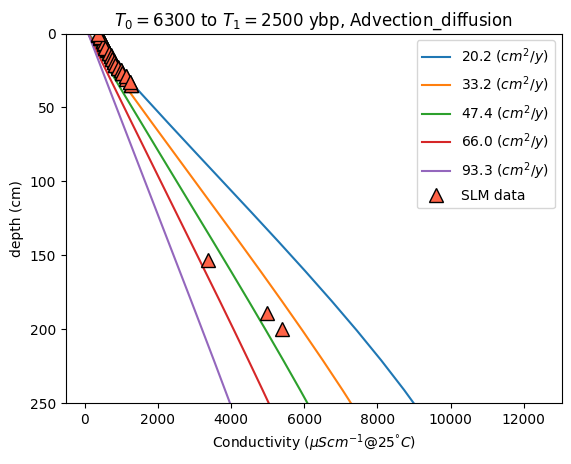

In [7]:
#Make a figure to compare the last members of the Phase 2 arrays calculated above to the data:
fig, ax = plt.subplots(nrows=1, ncols=1)

for k, v in Phase_2_diff_dict.items():
    ax.plot(v[-1, :], z, label=k+' $(cm^2/y)$')
    ax.set(title='$T_0 = $'+str(T_0)+' to $T_1 = $'+str(T_1)+' ybp, '+tag, ylabel='depth (cm)', xlabel='Conductivity ($\mu S cm^{-1} @ 25^°C$)', ylim=[0, 250])
    
ax.plot(cond, depth, linestyle='', marker='^', mec='k', color='tomato', markersize=10, label='SLM data')
ax.yaxis.set_inverted(True)
ax.legend()

## Diffusivity Sensitivity
These results show that the deeper salinity measurements are indicative of a wide range of diffusivities at this time window and this advection value. Similarly, we can take away advection or make it stronger to modulate the slope of these lines to match the slope of the data. This would optimize the model for insensivity to overall pooled conductivity. One can make the argument that in the situation of mixing freshwater with saltwater without significant biological reactions involving the salts that contribute to conductivity, that this system should not differ widely with different diffusivity cooefficients. 

## Temperature profiles in the ice

Neuhaus et al., 2020, breaks from convention in assuming that observed unsteady thermal states in vertical temperature profiles in Siple Coast ice are due to Holocene ice shelf re-grounding in the region. Previous workers had constrained the reasons for this temperature profiles to:
    1. cooling the surface temperature
    2. increasing the vertical advection (accumulation)
    3. increasing the horizontal advection (ice velocity)
Engelhardt settled on horizontal advection (2004), but was unable to reproduce the high basal temperature gradients wihout invoking basal melt.

Neuhaus et al. 2020 assume that this area was a grounded ice shelf in the past, an assumption supported by Kingslake et al. 2018 paper. They focused on Kamb Ice Stream, Bindschadler Ice Stream, and Unicorn due to very steep basal temperature gradients. Temperature gradients were modeled before and after grounding as in Bindschadler et al., 1990. The modeled basal temperaure gradients were compared to the observed (Engelhardt, 2004). The following cells aim to model the temperature profile through the ice, first using all boundary conditions and assumptions of Neuhaus et al., and then changing to those likely or measured for SLM. 

### Phase 1: Floating ice
The model is run with a 1 year time step and a 10m vertical spatial step. This is to satisfy the von Neumann stability condition. A constant surface temperature of -25 C is used and a bottom temperature equal to the freezing point of salt water at a salinity of 34. Pressure relates to ice thickness using Equation 5 in Begeman 2018. Surface accumulation rate was set to a constant 0.15 m/y based on observations at Siple Dome (Waddington et al., 2005). The ice shelf was assumed in steady state; basal melt rate was set to equal the surface accumulation rate. Horizontal advection is ignored. Starting ice shelf thickness was varied between 500 and 1000 m based on modern ice thickness of the Ross Ice Shelf. The result of phase 1 modeling is a temperature profile that serves as the initial condition for Phase 2. 

In [8]:
#Phase 1 temperature model:

#Linear Temperature Gradient:
ice_thickness = np.linspace(500, 1000, 5)

#Temperature and diffusivity profiles (initialization):
profiles_dict = {}
alpha_star_dict = {}
for j, thick in enumerate(ice_thickness):
    base_temp = 0.081 - 0.0568*S - 6.858e-4*thick       #Equation S13, modified from Begeman et al., 2018
    depths = np.linspace(0, thick, 100)
    profile = np.linspace(-25, base_temp, 100)
    alpha_star = [33.8 - 0.3514*t for t in profile]     #Equation S12, uncited and underived                          
    df = pd.DataFrame({'depth':depths, 'temperature':profile})
    profiles_dict |= {str(round(thick, 0)):df}

print(profiles_dict.keys())



dict_keys(['500.0', '625.0', '750.0', '875.0', '1000.0'])


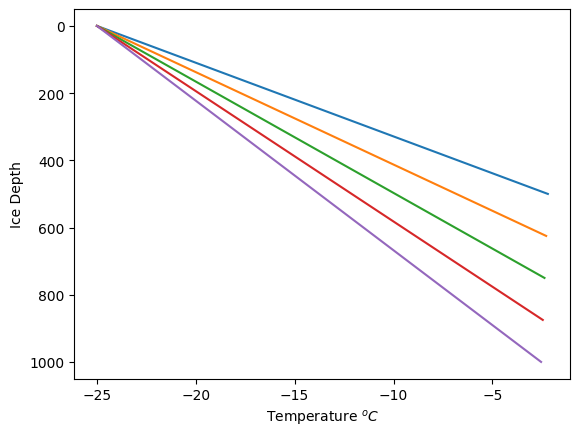

In [9]:
#Plot initialization profiles
fig, ax = plt.subplots(nrows=1, ncols=1)

for k, v in profiles_dict.items():
    ax.plot(v.temperature, v.depth, label=k+'m ice z')
    ax.set(xlabel='Temperature $^oC$', ylabel='Ice Depth')
    ax.yaxis.set_inverted(True)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1.]
200


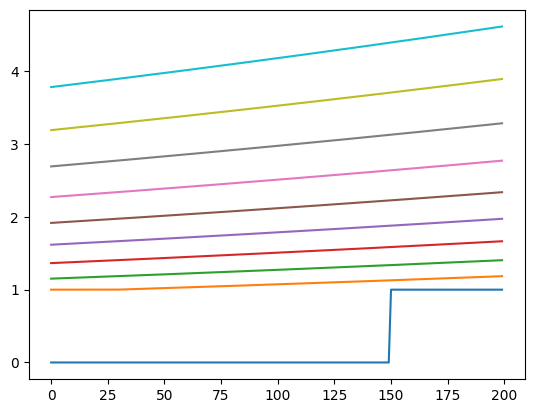

In [10]:
# Initialize concentraton array with a square wave:
c = np.zeros(Nx)
c[Nx//4*3:] = 1      # from three fourths to the end of C is 1 - square wave.
print(c)

# Create an array to store concentrations at each time step
c_history = np.zeros((Nt_T1, Nx))
c_history[0, :] = c # initial condition?

for t in range(1, Nt_T1):
    if t > 0:
        c = c[1:]       #get rid of first concentration
        c = np.append(c, (c[-1])*1.001)
    #for j in range(1, Nx - 1):
    #    c[j] = c[j] + u*dt/dx*(c[j-1] - c[j]) + D *dt/dx**2*(c[j+1] - 2*c[j] +c[j-1])
    c_history[t,:] = c

fig, ax = plt.subplots(nrows=1, ncols=1)
slice = 10
for t in range(0, Nt_T1, Nt_T1//slice):     # plot every "Nt//slice" time step
    ax.plot(c_history[t, :], label=f'Time Step {t}')

print(len(c_history[3,:]))
